In [2]:
!pip install --upgrade transformers accelerate
!pip install medmnist tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 104.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 5.0.0
    Uninstalling transformers-5.0.0:
      Successfully uninstalled transformers-5.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 7.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

from medmnist import PneumoniaMNIST, INFO

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
data_flag = "pneumoniamnist"
info = INFO[data_flag]

print("Task:", info["task"])
print("Number of classes:", len(info["label"]))
print("Labels:", info["label"])


Task: binary-class
Number of classes: 2
Labels: {'0': 'normal', '1': 'pneumonia'}


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


In [7]:
train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.35MB/s]

Train size: 4708
Val size: 524
Test size: 624


In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

print("Model ready.")


Model ready.


In [10]:
# Get labels from training dataset
train_labels = train_dataset.labels.squeeze()

class_counts = np.bincount(train_labels)
print("Class counts:", class_counts)

class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights_tensor)


Class counts: [1214 3494]
Class weights: tensor([0.7421, 0.2579], device='cuda:0')


In [11]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.squeeze().long().to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Val Accuracy: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved.")

    print("Training complete.")


In [13]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)


100%|██████████| 74/74 [00:21<00:00,  3.40it/s]



Epoch 1/5
Train Accuracy: 0.8796
Val Accuracy: 0.9427
Best model saved.


100%|██████████| 74/74 [00:27<00:00,  2.69it/s]



Epoch 2/5
Train Accuracy: 0.9429
Val Accuracy: 0.7748


100%|██████████| 74/74 [00:20<00:00,  3.57it/s]



Epoch 3/5
Train Accuracy: 0.9431
Val Accuracy: 0.9466
Best model saved.


100%|██████████| 74/74 [00:21<00:00,  3.49it/s]



Epoch 4/5
Train Accuracy: 0.9531
Val Accuracy: 0.9466


100%|██████████| 74/74 [00:21<00:00,  3.39it/s]



Epoch 5/5
Train Accuracy: 0.9590
Val Accuracy: 0.9332
Training complete.


In [14]:
# Load best saved model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

print("Best model loaded.")


Best model loaded.


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.93      0.69      0.79       234
           1       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.87      0.87      0.86       624



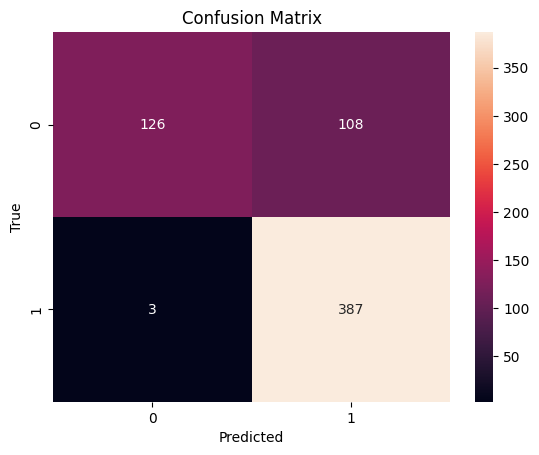

In [15]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [16]:
auc = roc_auc_score(all_labels, all_probs)
print("AUC:", auc)


AUC: 0.9426364234056543


In [19]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

model_id = "Salesforce/blip2-flan-t5-xl"

print("Loading processor...")
processor = Blip2Processor.from_pretrained(model_id)

print("Loading model...")
model_vlm = Blip2ForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

print("Model loaded successfully.")


Loading processor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Loading model...


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/1289 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie language_model.shared.weight to language_model.lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Model loaded successfully.


['correct_pneumonia_0.png', 'correct_normal_0.png', 'false_positive_0.png', 'correct_normal_2.png', 'correct_pneumonia_2.png', 'correct_pneumonia_1.png', 'correct_normal_1.png', 'false_negative_0.png', 'false_negative_1.png', 'false_positive_1.png']


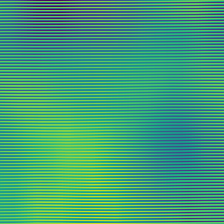

In [20]:
from PIL import Image
import os

# List available images
print(os.listdir("task2_samples"))

# Pick one image
image_path = "task2_samples/" + os.listdir("task2_samples")[0]

image = Image.open(image_path).convert("RGB")

image


In [25]:
prompt = "Question: You are a radiologist. Describe the findings in this chest X-ray and indicate whether pneumonia is present. Answer:"


In [26]:
inputs = processor(image, prompt, return_tensors="pt").to("cuda", torch.float16)

generated_ids = model_vlm.generate(
    **inputs,
    max_new_tokens=200,
    temperature=0.7
)

generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True
)[0]

print(generated_text)



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


a pleural effusion


In [28]:
import os
import matplotlib.pyplot as plt

os.makedirs("task2_samples_clean", exist_ok=True)

correct_normal = 0
correct_pneumonia = 0
false_positive = 0
false_negative = 0
global_index = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(preds)):
            img = images[i].cpu()
            true = labels[i].item()
            pred = preds[i].item()

            if true == 0 and pred == 0 and correct_normal < 3:
                filename = f"idx{global_index}_true{true}_pred{pred}_correct_normal.png"
                correct_normal += 1

            elif true == 1 and pred == 1 and correct_pneumonia < 3:
                filename = f"idx{global_index}_true{true}_pred{pred}_correct_pneumonia.png"
                correct_pneumonia += 1

            elif true == 0 and pred == 1 and false_positive < 2:
                filename = f"idx{global_index}_true{true}_pred{pred}_false_positive.png"
                false_positive += 1

            elif true == 1 and pred == 0 and false_negative < 2:
                filename = f"idx{global_index}_true{true}_pred{pred}_false_negative.png"
                false_negative += 1
            else:
                global_index += 1
                continue

            plt.imsave(
                f"task2_samples_clean/{filename}",
                img.permute(1, 2, 0)
            )

            global_index += 1

        if (correct_normal >= 3 and correct_pneumonia >= 3
            and false_positive >= 2 and false_negative >= 2):
            break

print("Clean images saved.")


Clean images saved.


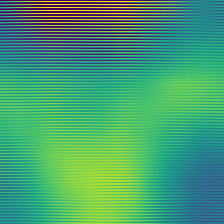

In [36]:
from PIL import Image

image_path = "task2_samples_clean/idx3_true0_pred0_correct_normal.png"
image = Image.open(image_path).convert("RGB")

image



In [39]:
prompt = "Question: What is in this image? Answer:"


In [40]:
inputs = processor(image, prompt, return_tensors="pt").to("cuda", torch.float16)

generated_ids = model_vlm.generate(
    **inputs,
    max_new_tokens=150
)

generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True
)[0]

print("Filename:", image_path)
print("\nGenerated Report:\n")
print(generated_text)


Filename: task2_samples_clean/idx3_true0_pred0_correct_normal.png

Generated Report:

a green and blue background


In [41]:
results = []

prompt = "Question: You are a radiologist. Describe the findings in this chest X-ray and state whether pneumonia is present. Answer:"

for filename in os.listdir("task2_samples_clean"):
    image_path = os.path.join("task2_samples_clean", filename)
    image = Image.open(image_path).convert("RGB")

    inputs = processor(image, prompt, return_tensors="pt").to("cuda", torch.float16)

    generated_ids = model_vlm.generate(
        **inputs,
        max_new_tokens=150
    )

    generated_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )[0]

    results.append({
        "filename": filename,
        "vlm_report": generated_text
    })

for r in results:
    print("\n---")
    print("Filename:", r["filename"])
    print("Report:", r["vlm_report"])



---
Filename: idx2_true1_pred1_correct_pneumonia.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx102_true1_pred0_false_negative.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx9_true0_pred1_false_positive.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx533_true1_pred0_false_negative.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx3_true0_pred0_correct_normal.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx19_true0_pred0_correct_normal.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx4_true1_pred1_correct_pneumonia.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx1_true0_pred1_false_positive.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx20_true0_pred0_correct_normal.png
Report: a pleural effusion with a pleural effusion

---
Filename: idx0_true1_pred1_correct_pneumonia.png
Report: a pleura

In [42]:
import pandas as pd

df_results = pd.DataFrame(results)
df_results


,filename,vlm_report
0,idx2_true1_pred1_correct_pneumonia.png,a pleural effusion with a pleural effusion
1,idx102_true1_pred0_false_negative.png,a pleural effusion with a pleural effusion
2,idx9_true0_pred1_false_positive.png,a pleural effusion with a pleural effusion
3,idx533_true1_pred0_false_negative.png,a pleural effusion with a pleural effusion
4,idx3_true0_pred0_correct_normal.png,a pleural effusion with a pleural effusion
5,idx19_true0_pred0_correct_normal.png,a pleural effusion with a pleural effusion
6,idx4_true1_pred1_correct_pneumonia.png,a pleural effusion with a pleural effusion
7,idx1_true0_pred1_false_positive.png,a pleural effusion with a pleural effusion
8,idx20_true0_pred0_correct_normal.png,a pleural effusion with a pleural effusion
9,idx0_true1_pred1_correct_pneumonia.png,a pleural effusion with a pleural effusion


In [43]:
df_results.to_csv("task2_vlm_results.csv", index=False)


In [16]:
import torch.nn as nn

model.eval()

# Remove final fully connected layer
embedding_model = nn.Sequential(*list(model.children())[:-1])
embedding_model = embedding_model.to(device)
embedding_model.eval()

print("Embedding model ready.")



Embedding model ready.


In [17]:
import numpy as np

embeddings = []
labels_array = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        features = embedding_model(images)
        features = features.view(features.size(0), -1)  # flatten

        embeddings.append(features.cpu().numpy())
        labels_array.append(labels.squeeze().numpy())

embeddings = np.vstack(embeddings)
labels_array = np.concatenate(labels_array)

print("Embeddings shape:", embeddings.shape)
print("Labels shape:", labels_array.shape)


Embeddings shape: (624, 512)
Labels shape: (624,)


In [18]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 56.1 MB/s eta 0:00:00


In [19]:
import faiss

dimension = embeddings.shape[1]

index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

print("FAISS index built.")
print("Total vectors:", index.ntotal)


FAISS index built.
Total vectors: 624


In [20]:
def retrieve_similar(query_index, k=5):
    query_embedding = embeddings[query_index].reshape(1, -1)
    distances, indices = index.search(query_embedding, k)
    return indices[0]


In [21]:
query_idx = 10
top_k = retrieve_similar(query_idx, k=5)

print("Query label:", labels_array[query_idx])
print("Retrieved labels:", labels_array[top_k])


Query label: 1
Retrieved labels: [1 1 1 1 1]


In [22]:
def precision_at_k(k=5):
    correct = 0
    total = 0

    for i in range(len(embeddings)):
        retrieved = retrieve_similar(i, k)
        query_label = labels_array[i]

        matches = sum(labels_array[idx] == query_label for idx in retrieved)

        correct += matches
        total += k

    return correct / total

print("Precision@5:", precision_at_k(5))


Precision@5: 0.9073717948717949


In [24]:
import matplotlib.pyplot as plt

def visualize_retrieval(query_index, k=5):
    retrieved = retrieve_similar(query_index, k)

    plt.figure(figsize=(15,3))

    # Query image
    img, label = test_dataset[query_index]
    img = img.permute(1,2,0).numpy()

    plt.subplot(1, k+1, 1)
    plt.imshow(img)
    plt.title(f"Query\nLabel: {label.item()}")
    plt.axis("off")

    # Retrieved images
    for i, idx in enumerate(retrieved):
        img_r, label_r = test_dataset[idx]
        img_r = img_r.permute(1,2,0).numpy()

        plt.subplot(1, k+1, i+2)
        plt.imshow(img_r)
        plt.title(f"Label: {label_r.item()}")
        plt.axis("off")

    plt.show()


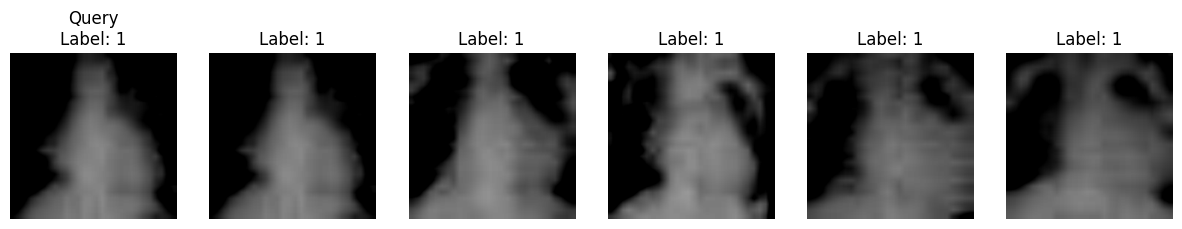

In [25]:
visualize_retrieval(10, k=5)
